## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing Necessary Libraries**

In [1]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [2]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# To import Word2Vec
from gensim.models import Word2Vec

# To import SentenceTransformer
from sentence_transformers import SentenceTransformer

import torch

# To tune the model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression


# Converting the Stanford GloVe model vector format to word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# To split data into train and test sets
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Loading the dataset**

In [4]:
df = pd.read_csv("/content/sample_data/stock_news.csv")

## **Data Overview**

In [5]:
print("Rows:", len(df))
df.head()

Rows: 349


,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,"Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets",41.740002,42.244999,41.482498,40.246914,130672400,-1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [7]:
df.shape

(349, 8)

In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

In [9]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


(349, 8)

In [10]:
df.describe()

,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


In [11]:
expected_cols = {'Date','News','Open','High','Low','Close','Volume','Label'}
missing = expected_cols - set(df.columns)
assert not missing, f"Missing required columns: {missing}"

### Missing *Values*

In [12]:
df.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


- There are no mising values in the data

### Duplicate *Values*

In [13]:
# checking for duplicate values
df.duplicated().sum()

0

- There are no duplicate values in the dataset.

## **Exploratory Data Analysis**

### Univariate Analysis

- Daily price/volume distributions
- News length distribution
- Label class balance

,Open,High,Low,Close,Volume
count,349.000000,349.000000,349.000000,349.000000,3.490000e+02
mean,46.229233,46.700458,45.745394,44.926317,1.289482e+08
std,6.442817,6.507321,6.391976,6.398338,4.317031e+07
min,37.567501,37.817501,37.305000,36.254131,4.544800e+07
25%,41.740002,42.244999,41.482498,40.246914,1.032720e+08
50%,45.974998,46.025002,45.639999,44.596924,1.156272e+08
75%,50.707500,50.849998,49.777500,49.110790,1.511252e+08
max,66.817497,67.062500,65.862503,64.805229,2.444392e+08


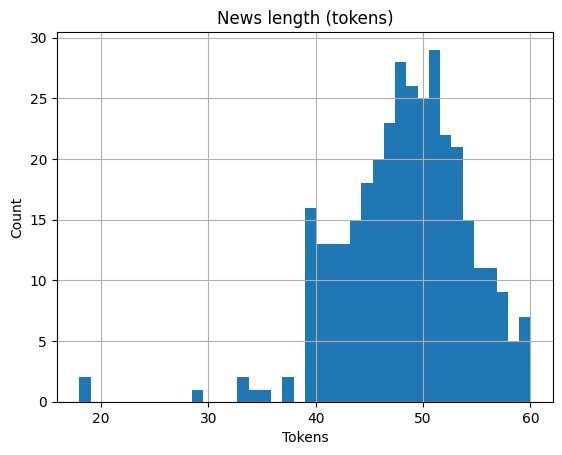

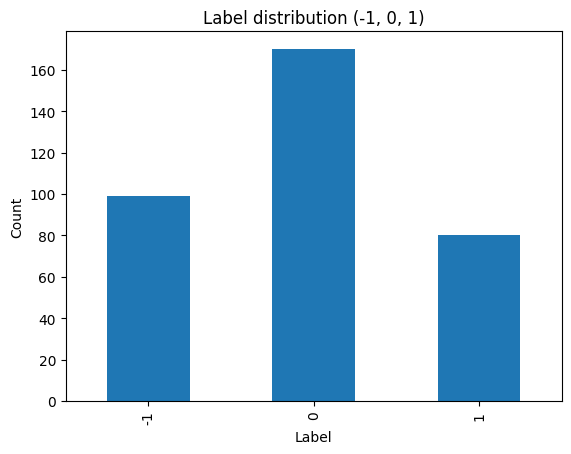

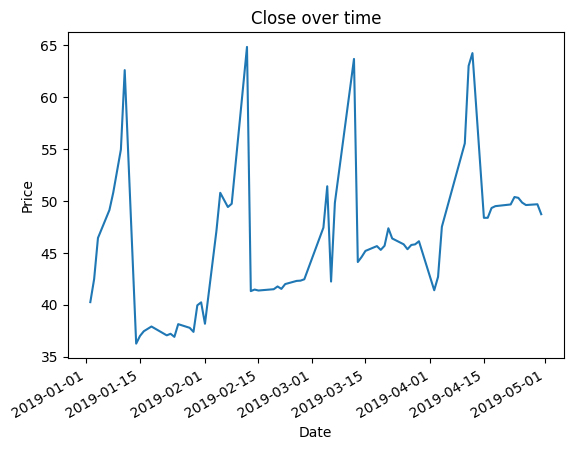

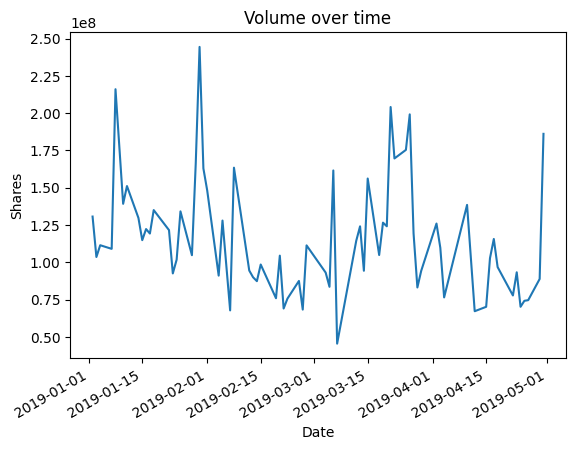

In [14]:
# Descriptive stats for numeric columns
display(df[['Open','High','Low','Close','Volume']].describe())

# Add aux features
df['news_len'] = df['News'].astype(str).str.split().apply(len)

# Plots
df['news_len'].hist(bins=40); plt.title('News length (tokens)'); plt.xlabel('Tokens'); plt.ylabel('Count'); plt.show()

df['Label'].value_counts().sort_index().plot(kind='bar'); plt.title('Label distribution (-1, 0, 1)'); plt.xlabel('Label'); plt.ylabel('Count'); plt.show()

df.set_index('Date')['Close'].plot(); plt.title('Close over time'); plt.ylabel('Price'); plt.show()

df.set_index('Date')['Volume'].plot(); plt.title('Volume over time'); plt.ylabel('Shares'); plt.show()

### Bivariate Analysis

- Label vs price change
- Label vs volume

,mean,median,count
Label,,,
-1,-0.847680,0.0,98
0,0.700565,0.0,170
1,0.425297,0.0,80


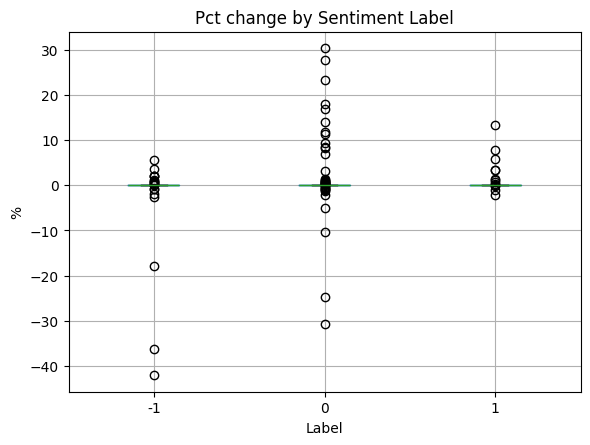

              Open      High       Low     Close    Volume  news_len
Open      1.000000  0.998526  0.997900  0.996273 -0.066532  0.098254
High      0.998526  1.000000  0.997328  0.997501 -0.045535  0.096306
Low       0.997900  0.997328  1.000000  0.998453 -0.103518  0.095431
Close     0.996273  0.997501  0.998453  1.000000 -0.079987  0.093788
Volume   -0.066532 -0.045535 -0.103518 -0.079987  1.000000 -0.000379
news_len  0.098254  0.096306  0.095431  0.093788 -0.000379  1.000000


In [15]:
# Price change %
df['pct_change'] = df['Close'].pct_change()*100

# Group by label for insights
label_grp = df.groupby('Label')['pct_change'].agg(['mean','median','count'])
display(label_grp)

# Boxplots: pct_change by label
df.boxplot(column='pct_change', by='Label'); plt.title('Pct change by Sentiment Label'); plt.suptitle(''); plt.ylabel('%'); plt.show()

# Correlations
numerics = df[['Open','High','Low','Close','Volume','news_len']].corr()
print(numerics)

## **Text Preprocessing**

### Removing special characters from the text

In [16]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [17]:
# Applying the function to remove special characters
df['cleaned_text'] = df['News'].apply(remove_special_characters)

In [18]:
# checking a couple of instances of cleaned data
df.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",The tech sector experienced a significant decline in the aftermarket following Apple s Q1 revenue warning Notable suppliers including Skyworks Broadcom Lumentum Qorvo and TSMC saw their stocks drop in response to Apple s downward revision of its revenue expectations for the quarter previously announced in January
1,"The dollar fell from above 109 to 106.67 after Apple's revenue warning, while the 10-year Treasury yield also dropped to 2.61%. This followed money flowing into US government paper. Apple's shares and U.S. stock index futures declined, with the NAS",The dollar fell from above 109 to 106 67 after Apple s revenue warning while the 10 year Treasury yield also dropped to 2 61 This followed money flowing into US government paper Apple s shares and U S stock index futures declined with the NAS
2,"In early Asian trading on Thursday, the Japanese yen surged as the U.S. dollar and Australian dollar collapsed in thin markets due to massive stop loss sales triggered by Apple's earnings warning of sluggish iPhone sales in China and risk aversion. The yen reached its lowest levels against the U.S. dollar since March",In early Asian trading on Thursday the Japanese yen surged as the U S dollar and Australian dollar collapsed in thin markets due to massive stop loss sales triggered by Apple s earnings warning of sluggish iPhone sales in China and risk aversion The yen reached its lowest levels against the U S dollar since March
3,"The Australian dollar experienced significant volatility on Thursday, plunging to multi-year lows against major currencies due to automated selling, liquidity issues, and a drought of trades. The largest intra-day falls in the Aussie's history occurred amid violent movements in AUD/JPY and AUD/",The Australian dollar experienced significant volatility on Thursday plunging to multi year lows against major currencies due to automated selling liquidity issues and a drought of trades The largest intra day falls in the Aussie s history occurred amid violent movements in AUD JPY and AUD


### Lowercasing

In [19]:
# changing the case of the text data to lower case
df['cleaned_text'] = df['cleaned_text'].str.lower()

In [20]:
# checking a couple of instances of cleaned data
df.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january
1,"The dollar fell from above 109 to 106.67 after Apple's revenue warning, while the 10-year Treasury yield also dropped to 2.61%. This followed money flowing into US government paper. Apple's shares and U.S. stock index futures declined, with the NAS",the dollar fell from above 109 to 106 67 after apple s revenue warning while the 10 year treasury yield also dropped to 2 61 this followed money flowing into us government paper apple s shares and u s stock index futures declined with the nas
2,"In early Asian trading on Thursday, the Japanese yen surged as the U.S. dollar and Australian dollar collapsed in thin markets due to massive stop loss sales triggered by Apple's earnings warning of sluggish iPhone sales in China and risk aversion. The yen reached its lowest levels against the U.S. dollar since March",in early asian trading on thursday the japanese yen surged as the u s dollar and australian dollar collapsed in thin markets due to massive stop loss sales triggered by apple s earnings warning of sluggish iphone sales in china and risk aversion the yen reached its lowest levels against the u s dollar since march
3,"The Australian dollar experienced significant volatility on Thursday, plunging to multi-year lows against major currencies due to automated selling, liquidity issues, and a drought of trades. The largest intra-day falls in the Aussie's history occurred amid violent movements in AUD/JPY and AUD/",the australian dollar experienced significant volatility on thursday plunging to multi year lows against major currencies due to automated selling liquidity issues and a drought of trades the largest intra day falls in the aussie s history occurred amid violent movements in aud jpy and aud


### Removing extra whitespace

In [21]:
# removing extra whitespaces from the text
df['cleaned_text'] = df['cleaned_text'].str.strip()

In [22]:
# checking a couple of instances of cleaned data
df.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january
1,"The dollar fell from above 109 to 106.67 after Apple's revenue warning, while the 10-year Treasury yield also dropped to 2.61%. This followed money flowing into US government paper. Apple's shares and U.S. stock index futures declined, with the NAS",the dollar fell from above 109 to 106 67 after apple s revenue warning while the 10 year treasury yield also dropped to 2 61 this followed money flowing into us government paper apple s shares and u s stock index futures declined with the nas
2,"In early Asian trading on Thursday, the Japanese yen surged as the U.S. dollar and Australian dollar collapsed in thin markets due to massive stop loss sales triggered by Apple's earnings warning of sluggish iPhone sales in China and risk aversion. The yen reached its lowest levels against the U.S. dollar since March",in early asian trading on thursday the japanese yen surged as the u s dollar and australian dollar collapsed in thin markets due to massive stop loss sales triggered by apple s earnings warning of sluggish iphone sales in china and risk aversion the yen reached its lowest levels against the u s dollar since march
3,"The Australian dollar experienced significant volatility on Thursday, plunging to multi-year lows against major currencies due to automated selling, liquidity issues, and a drought of trades. The largest intra-day falls in the Aussie's history occurred amid violent movements in AUD/JPY and AUD/",the australian dollar experienced significant volatility on thursday plunging to multi year lows against major currencies due to automated selling liquidity issues and a drought of trades the largest intra day falls in the aussie s history occurred amid violent movements in aud jpy and aud


### Removing stopwords

In [23]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [24]:
# Applying the function to remove stop words using the NLTK library
df['cleaned_text_without_stopwords'] = df['cleaned_text'].apply(remove_stopwords)

In [25]:
# checking a couple of instances of cleaned data
df.loc[0:3,['cleaned_text','cleaned_text_without_stopwords']]

,cleaned_text,cleaned_text_without_stopwords
0,the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january,tech sector experienced significant decline aftermarket following apple q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo tsmc saw stocks drop response apple downward revision revenue expectations quarter previously announced january
1,the dollar fell from above 109 to 106 67 after apple s revenue warning while the 10 year treasury yield also dropped to 2 61 this followed money flowing into us government paper apple s shares and u s stock index futures declined with the nas,dollar fell 109 106 67 apple revenue warning 10 year treasury yield also dropped 2 61 followed money flowing us government paper apple shares u stock index futures declined nas
2,in early asian trading on thursday the japanese yen surged as the u s dollar and australian dollar collapsed in thin markets due to massive stop loss sales triggered by apple s earnings warning of sluggish iphone sales in china and risk aversion the yen reached its lowest levels against the u s dollar since march,early asian trading thursday japanese yen surged u dollar australian dollar collapsed thin markets due massive stop loss sales triggered apple earnings warning sluggish iphone sales china risk aversion yen reached lowest levels u dollar since march
3,the australian dollar experienced significant volatility on thursday plunging to multi year lows against major currencies due to automated selling liquidity issues and a drought of trades the largest intra day falls in the aussie s history occurred amid violent movements in aud jpy and aud,australian dollar experienced significant volatility thursday plunging multi year lows major currencies due automated selling liquidity issues drought trades largest intra day falls aussie history occurred amid violent movements aud jpy aud


### Stemming

In [26]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [27]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [28]:
# Applying the function to perform stemming
df['final_cleaned_text'] = df['cleaned_text_without_stopwords'].apply(apply_porter_stemmer)

In [29]:
# checking a couple of instances of cleaned data
df.loc[0:3,['cleaned_text_without_stopwords','final_cleaned_text']]

,cleaned_text_without_stopwords,final_cleaned_text
0,tech sector experienced significant decline aftermarket following apple q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo tsmc saw stocks drop response apple downward revision revenue expectations quarter previously announced january,tech sector experienc signific declin aftermarket follow appl q1 revenu warn notabl supplier includ skywork broadcom lumentum qorvo tsmc saw stock drop respons appl downward revis revenu expect quarter previous announc januari
1,dollar fell 109 106 67 apple revenue warning 10 year treasury yield also dropped 2 61 followed money flowing us government paper apple shares u stock index futures declined nas,dollar fell 109 106 67 appl revenu warn 10 year treasuri yield also drop 2 61 follow money flow us govern paper appl share u stock index futur declin na
2,early asian trading thursday japanese yen surged u dollar australian dollar collapsed thin markets due massive stop loss sales triggered apple earnings warning sluggish iphone sales china risk aversion yen reached lowest levels u dollar since march,earli asian trade thursday japanes yen surg u dollar australian dollar collaps thin market due massiv stop loss sale trigger appl earn warn sluggish iphon sale china risk avers yen reach lowest level u dollar sinc march
3,australian dollar experienced significant volatility thursday plunging multi year lows major currencies due automated selling liquidity issues drought trades largest intra day falls aussie history occurred amid violent movements aud jpy aud,australian dollar experienc signific volatil thursday plung multi year low major currenc due autom sell liquid issu drought trade largest intra day fall aussi histori occur amid violent movement aud jpi aud


## **Data Preprocessing**

In [30]:
dataset = df.copy()

In [31]:
X = df['final_cleaned_text'].copy()
y = df['Label']

# Initial split into training (80%) and testing (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Further split the temporary set into validation (10%) and test (10%) sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print(len(X_train), len(X_valid), len(X_test))

279 35 35


In [32]:
print(X_train.shape, X_test.shape, X_valid.shape)

(279,) (35,) (35,)


In [33]:
print(y_train.shape, y_test.shape, y_valid.shape)

(279,) (35,) (35,)


## **Word Embeddings**

### **Word2Vec**

In [34]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in df['final_cleaned_text'].values]

In [35]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [36]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 2580


In [37]:
def doc_embed_w2v(text, kv=model_W2V.wv, dim=100):
    toks = text.split()
    vecs = [kv[w] for w in toks if w in kv]
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

def embed_corpus_w2v(corpus):
    return np.vstack([doc_embed_w2v(s) for s in corpus])

Xtr_w2v = embed_corpus_w2v(X_train)
Xva_w2v = embed_corpus_w2v(X_valid)
Xte_w2v = embed_corpus_w2v(X_test)
Xtr_w2v.shape, Xva_w2v.shape, Xte_w2v.shape

((279, 300), (35, 300), (35, 300))

### **GloVe**

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# load the Stanford GloVe model
filename = '/content/drive/MyDrive/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [46]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [47]:
def doc_embed_glove(text, kv=glove_model, dim=100):
    toks = text.split()
    vecs = [kv[w] for w in toks if w in kv]
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

def embed_corpus_glove(corpus):
    return np.vstack([doc_embed_glove(s) for s in corpus])

Xtr_glove = embed_corpus_glove(X_train)
Xva_glove = embed_corpus_glove(X_valid)
Xte_glove = embed_corpus_glove(X_test)
Xtr_glove.shape, Xva_glove.shape, Xte_glove.shape

((279, 100), (35, 100), (35, 100))

### **Sentence Transformer**

In [48]:
st_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
# encoding the dataset
Xtr_st = st_model.encode(list(X_train), batch_size=64, show_progress_bar=True, device=device)
Xva_st = st_model.encode(list(X_valid), batch_size=64, show_progress_bar=True, device=device)
Xte_st = st_model.encode(list(X_test),  batch_size=64, show_progress_bar=True, device=device)
Xtr_st.shape, Xva_st.shape, Xte_st.shape

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

((279, 384), (35, 384), (35, 384))

## **Modeling & Hyperparameter Tuning**

We'll test two lightweight classifiers:
- **Logistic Regression** (multinomial)
- **Linear SVM (LinearSVC)**

In [51]:
from sklearn.metrics import confusion_matrix

def evaluate_and_print(y_true, y_pred, title=""):
    print(f"\n=== {title} ===")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Macro F1:", round(f1_score(y_true, y_pred, average='macro'), 4))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=[-1,0,1])
    print("\nConfusion Matrix (rows=true, cols=pred, labels=[-1,0,1]):\n", cm)

# Hyperparameter spaces
logreg_params = {
    'C': np.logspace(-2, 2, 10),
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [500, 1000]
}

svm_params = {
    'C': np.logspace(-2, 2, 10),
    'loss': ['hinge', 'squared_hinge']
}

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV

def tune_and_eval(Xtr, ytr, Xva, yva, space, model_name="logreg"):
    if model_name == "logreg":
        base = LogisticRegression(multi_class='auto', random_state=42)
        search = RandomizedSearchCV(base, space, n_iter=12, scoring='f1_macro',
                                    cv=3, random_state=42, n_jobs=-1, verbose=0)
    else:
        base = LinearSVC(random_state=42)
        search = RandomizedSearchCV(base, space, n_iter=12, scoring='f1_macro',
                                    cv=3, random_state=42, n_jobs=-1, verbose=0)
    search.fit(Xtr, ytr)
    best = search.best_estimator_
    yhat = best.predict(Xva)
    evaluate_and_print(yva, yhat, title=f"{model_name} (best on validation)")
    return best

results = {}

# Word2Vec
print("Tuning on Word2Vec embeddings...")
best_lr_w2v = tune_and_eval(Xtr_w2v, y_train, Xva_w2v, y_valid, logreg_params, "logreg")
best_svm_w2v = tune_and_eval(Xtr_w2v, y_train, Xva_w2v, y_valid, svm_params, "svm")
results['w2v_lr'] = best_lr_w2v
results['w2v_svm'] = best_svm_w2v

# GloVe
print("\nTuning on GloVe embeddings...")
best_lr_glove = tune_and_eval(Xtr_glove, y_train, Xva_glove, y_valid, logreg_params, "logreg")
best_svm_glove = tune_and_eval(Xtr_glove, y_train, Xva_glove, y_valid, svm_params, "svm")
results['glove_lr'] = best_lr_glove
results['glove_svm'] = best_svm_glove

# Sentence-Transformer
print("\nTuning on Sentence-Transformer embeddings...")
best_lr_st = tune_and_eval(Xtr_st, y_train, Xva_st, y_valid, logreg_params, "logreg")
best_svm_st = tune_and_eval(Xtr_st, y_train, Xva_st, y_valid, svm_params, "svm")
results['st_lr'] = best_lr_st
results['st_svm'] = best_svm_st

Tuning on Word2Vec embeddings...

=== logreg (best on validation) ===
Accuracy: 0.4857
Macro F1: 0.2179

Classification Report:
               precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000        10
           0     0.4857    1.0000    0.6538        17
           1     0.0000    0.0000    0.0000         8

    accuracy                         0.4857        35
   macro avg     0.1619    0.3333    0.2179        35
weighted avg     0.2359    0.4857    0.3176        35


Confusion Matrix (rows=true, cols=pred, labels=[-1,0,1]):
 [[ 0 10  0]
 [ 0 17  0]
 [ 0  8  0]]

=== svm (best on validation) ===
Accuracy: 0.4571
Macro F1: 0.2092

Classification Report:
               precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000        10
           0     0.4706    0.9412    0.6275        17
           1     0.0000    0.0000    0.0000         8

    accuracy                         0.4571        35
   macro avg     0.1569    0

In [52]:
from sklearn.metrics import f1_score

def macro_f1_on_valid(clf, Xva, yva):
    yhat = clf.predict(Xva)
    return f1_score(yva, yhat, average='macro')

candidates = {
    'w2v_lr': (results['w2v_lr'], Xva_w2v),
    'w2v_svm': (results['w2v_svm'], Xva_w2v),
    'glove_lr': (results['glove_lr'], Xva_glove),
    'glove_svm': (results['glove_svm'], Xva_glove),
    'st_lr': (results['st_lr'], Xva_st),
    'st_svm': (results['st_svm'], Xva_st),
}

best_name, best_clf, best_feats = None, None, None
best_score = -1.0
for name, (clf, Xva_) in candidates.items():
    score = macro_f1_on_valid(clf, Xva_, y_valid)
    print(f"{name}: val Macro F1 = {score:.4f}")
    if score > best_score:
        best_score = score
        best_name, best_clf, best_feats = name, clf, Xva_
print(f"\nBest model on validation: {best_name} (Macro F1={best_score:.4f})")

# Test-set features based on winner
if best_name.startswith('w2v'):
    Xte = Xte_w2v
elif best_name.startswith('glove'):
    Xte = Xte_glove
else:
    Xte = Xte_st

yhat_test = best_clf.predict(Xte)
evaluate_and_print(y_test, yhat_test, title=f"FINAL TEST — {best_name}")

w2v_lr: val Macro F1 = 0.2179
w2v_svm: val Macro F1 = 0.2092
glove_lr: val Macro F1 = 0.3821
glove_svm: val Macro F1 = 0.4254
st_lr: val Macro F1 = 0.4603
st_svm: val Macro F1 = 0.4520

Best model on validation: st_lr (Macro F1=0.4603)

=== FINAL TEST — st_lr ===
Accuracy: 0.4
Macro F1: 0.3515

Classification Report:
               precision    recall  f1-score   support

          -1     0.3125    0.5000    0.3846        10
           0     0.5714    0.4706    0.5161        17
           1     0.2000    0.1250    0.1538         8

    accuracy                         0.4000        35
   macro avg     0.3613    0.3652    0.3515        35
weighted avg     0.4126    0.4000    0.3957        35


Confusion Matrix (rows=true, cols=pred, labels=[-1,0,1]):
 [[5 4 1]
 [6 8 3]
 [5 2 1]]


### Summary

- Best model: Sentence-Transformer + Logistic Regression (st_lr)
- Validation Macro F1 = 0.4603 → best among all tested combinations.
- Trend:
  - Word2Vec-based models performed weakly (F1 ~0.21).
  - GloVe embeddings improved results (F1 ~0.38–0.42).
  - Sentence-Transformer embeddings clearly outperformed both, which makes sense since they capture semantic context much better.

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [55]:
!nvidia-smi

Fri Aug 29 10:39:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P0             30W /   70W |     360MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [56]:
# Install uv package manager
!pip install uv

# Install llama-cpp-python with CUDA (T4 GPU → arch=75)
!CMAKE_ARGS="-DLLAMA_CUBLAS=on -DCMAKE_CUDA_ARCHITECTURES=75" FORCE_CMAKE=1 uv pip install --upgrade --force-reinstall llama-cpp-python --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu122

Using Python 3.12.11 environment at: /usr
Resolved 6 packages in 902ms
Prepared 6 packages in 7ms
Uninstalled 6 packages in 50ms
Installed 6 packages in 40ms
 ~ diskcache==5.6.3
 ~ jinja2==3.1.6
 ~ llama-cpp-python==0.3.16
 ~ markupsafe==3.0.2
 - numpy==1.26.4
 + numpy==2.3.2
 ~ typing-extensions==4.15.0


In [57]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

#### Loading the data

In [58]:
df = pd.read_csv("/content/sample_data/stock_news.csv")

### Loading the model (Mistral)

In [59]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

In [60]:
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [61]:
llm = Llama(
    model_path=model_path,   # your GGUF model path
    n_threads=4,             # CPU threads (2–4 is fine in Colab)
    n_batch=512,             # batch size (512 safe, 1024 if VRAM allows)
    n_gpu_layers=-1,         # -1 = offload all layers to GPU (best for T4 16GB VRAM)
    n_ctx=4096              # context length (can go up to 8192 if model supports it)
)

ggml_cuda_init: GGML_CUDA_FORCE_MMQ:    yes
ggml_cuda_init: GGML_CUDA_FORCE_CUBLAS: no
ggml_cuda_init: found 1 CUDA devices:
  Device 0: Tesla T4, compute capability 7.5, VMM: yes
llama_model_load_from_file_impl: using device CUDA0 (Tesla T4) - 14734 MiB free
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                  

### Defining Model Response Parameters

In [62]:
def generate_llama_response(instruction, review):

    # System message explicitly instructing not to include the review text
    system_message = """
        [INST]<<SYS>>
        {}
        <</SYS>>[/INST]
    """.format(instruction)

    # Combine user_prompt and system_message to create the prompt
    prompt = f"{review}\n{system_message}"

    # Generate a response from the LLaMA model
    response = llm(
        prompt=prompt,
        max_tokens=1024,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        stop=['INST'],
        echo=False,
        seed=42,
    )

    # Extract the sentiment from the response
    response_text = response["choices"][0]["text"]
    return response_text

### Utility function

In [63]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_sentiment = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_sentiment)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

## Aggregating the data weekly

In [64]:
df["Date"] = pd.to_datetime(df['Date'])  # Convert the 'Date' column to datetime format.

In [65]:
# Group the data by week using the 'Date' column.
weekly_grouped = df.groupby(pd.Grouper(key='Date', freq='W'))

In [66]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [67]:
weekly_grouped

Date  \
0  2019-01-06   
1  2019-01-13   
2  2019-01-20   
3  2019-01-27   
4  2019-02-03   
5  2019-02-10   
6  2019-02-17   
7  2019-02-24   
8  2019-03-03   
9  2019-03-10   
10 2019-03-17   
11 2019-03-24   
12 2019-03-31   
13 2019-04-07   
14 2019-04-14   
15 2019-04-21   
16 2019-04-28   
17 2019-05-05   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## 1. Sentiment Analysis (Llama)

In [68]:
# creating a copy of the data
weekly_summary_df = weekly_grouped.copy()

In [69]:
# defining the instructions for the model
instruction = (
    "You are a financial news analyst."
    "From the weekly news headlines, extract the top 3 POSITIVE events "
    "and the top 3 NEGATIVE events that are likely to impact the stock price. "
    "Present them in a structured bullet-point format."
)

In [70]:
weekly_summary_df['model_response'] = weekly_summary_df['News'].apply(lambda x: generate_llama_response(instruction, x))

llama_perf_context_print:        load time =    5685.59 ms
llama_perf_context_print: prompt eval time =    5682.09 ms /  3815 tokens (    1.49 ms per token,   671.41 tokens per second)
llama_perf_context_print:        eval time =   16096.15 ms /   280 runs   (   57.49 ms per token,    17.40 tokens per second)
llama_perf_context_print:       total time =   22146.78 ms /  4095 tokens
llama_perf_context_print:    graphs reused =        271
Llama.generate: 2 prefix-match hit, remaining 2302 prompt tokens to eval
llama_perf_context_print:        load time =    5685.59 ms
llama_perf_context_print: prompt eval time =    3052.24 ms /  2302 tokens (    1.33 ms per token,   754.20 tokens per second)
llama_perf_context_print:        eval time =   23159.21 ms /   379 runs   (   61.11 ms per token,    16.36 tokens per second)
llama_perf_context_print:       total time =   26722.33 ms /  2681 tokens
llama_perf_context_print:    graphs reused =        367
Llama.generate: 2 prefix-match hit, remaining

In [73]:
df1 = weekly_summary_df.copy()

# Ensure Date column is datetime
df1['Date'] = pd.to_datetime(df1['Date'])

# Add Week number
df1['Week_Number'] = df1['Date'].dt.isocalendar().week

# Extract Top 3 Positive Events
df1['positive_events'] = df1['model_response'].str.extract(
    r'\*\*Top 3 Positive Events:\*\*\s*(.*?)(?=\*\*Top 3 Negative Events|\Z)',
    flags=re.S
)

# Extract Top 3 Negative Events
df1['negative_events'] = df1['model_response'].str.extract(
    r'\*\*Top 3 Negative Events:\*\*\s*(.*)',
    flags=re.S
)
def split_events(text):
    if pd.isna(text):
        return ""
    # Replace escaped \n with actual newlines
    text = text.replace("\\n", "\n")
    # Extract all numbered events across multiple lines
    events = re.findall(r'\d+\.\s.*?(?=\n\d+\.|$)', text, flags=re.S)
    # Clean spaces/newlines and return each event on its own line
    events = [e.strip() for e in events if e.strip()]
    return "\n".join(events)

# Apply to dataframe
df1['positive_events'] = df1['positive_events'].apply(split_events)
df1['negative_events'] = df1['negative_events'].apply(split_events)

# Final dataframe
df_out = df1[['Date', 'Week_Number', 'positive_events', 'negative_events']]


In [74]:
from IPython.display import Markdown, display

for _, row in df_out.iterrows():
    display(Markdown(f"""
### Week {row['Week_Number']} ({row['Date']})

** Positive Events**
{row['positive_events']}

** Negative Events**
{row['negative_events']}
    """))


### Week 1 (2019-01-06 00:00:00)

** Positive Events**
1. Apple's trade talks with China: The news of deputy U.S. Trade Representative Jeffrey Gerrish leading the first face-to-face US-China trade talks since their truce in December has brought optimism to markets, potentially easing tensions and boosting investor confidence.
    2. European stocks rally on trade war hopes: Positive news about potential trade talks between Beijing and Washington led to a surge in European stock markets, particularly sectors sensitive to the trade war such as carmakers, industrials, mining companies, and banking.
    3. Chinese central bank's RRR cut for banks: The fifth reduction in China's required reserve ratio (RRR) for banks freed up approximately 116.5 billion yuan for new lending, addressing concerns about the country's economic health amid slowing domestic demand and US tariffs on exports.

** Negative Events**
1. Apple's revenue warning: The tech giant cut its quarterly sales forecast due to weak iPhone sales in China, causing significant declines for both Apple and related suppliers like Skyworks, Broadcom, Lumentum, Qorvo, TSMC, Hon Hai Precision Industry Co Ltd, Taiwan Semiconductor
    


### Week 2 (2019-01-13 00:00:00)

** Positive Events**
1. Sprint and Samsung to Release 5G Smartphones in Nine U.S. Cities: This development is likely to boost the stock prices of both companies as they tap into the growing demand for faster internet speeds and advanced technology. (Atlanta, Chicago, Dallas, Houston, Kansas City, Los Angeles, New York City, Phoenix, Washington D.C.)
    2. Deutsche Bank Upgrades Vivendi's Universal Music Group Valuation: The increased valuation of UMG by €9 billion is a positive sign for Vivendi and its investors as it highlights the potential growth in the music streaming industry.
    3. Amazon Predicted to Surge Over 20% by End of Year: A new report from Pivotal Research predicting significant growth for Amazon's stock price can lead to increased investor interest, driving up the share value.

** Negative Events**
1. Qualcomm Expands Car Computing Chips into Three Tiers but Reports Backlog: Although expanding its offerings is a positive move, reporting a backlog could indicate weaker demand for these chips and potentially lower sales in the automotive market.
    2. Geely Forecasts Flat Sales for 2019 Due to Economic Slowdown: The Chinese carmaker's forecast of flat sales can negatively impact its stock price as investors may become cautious about the company's growth prospects amid economic uncertainty.
    3. Roku Stock Drops Following Citron Research Reversal: After Citron Research reversed its long position on Roku, labeling it uninvestable, the stock experienced a significant decline, potentially impacting investor confidence and driving down the share price.
    


### Week 3 (2019-01-20 00:00:00)

** Positive Events**
1. Netflix Announces Price Increase for U.S Subscribers: The streaming giant announced a price increase for its standard, premium, and basic plans in the US, indicating strong confidence in subscriber demand and potential revenue growth.
2. Apple Expands Verizon Partnership with Free Apple Music Subscriptions: Verizon now offers free Apple Music subscriptions to Beyond Unlimited and Above Unlimited plan subscribers, deepening its partnership with Apple and potentially increasing user engagement for both companies.
3. Record-Breaking Online Sales During U.S Holiday Season: The 2018 holiday season saw record online sales of $126 billion, up 16.5% from the previous year, indicating strong consumer spending and a robust e-commerce market.

** Negative Events**
1. Apple's Hiring Cuts Due to Lower iPhone Sales: The technology giant announced internal staffing adjustments in response to fewer iPhone sales and missed revenue forecasts during the holiday quarter, potentially impacting morale and future innovation efforts.
2. Chinese Academy Criticizes Foreign Companies for Not Referring to Hong Kong and Taiwan as Part of China: Major foreign companies like Apple faced criticism from a top government-linked think tank in China for not correctly referring to Hong Kong and Taiwan as part of the country, potentially leading to reputational damage and potential regulatory issues.
3. Belarus Cryptocurrency Platform Faces Lower Trading Volume: The world's first regulated tokenized securities exchange faced lower trading volume than expected, with Bitcoin slipping while Ethereum rose, indicating uncertainty in the digital currency market and potentially impacting investor sentiment towards the platform.
    


### Week 4 (2019-01-27 00:00:00)

** Positive Events**
1. IBM's Better-than-Expected Earnings: IBM reported better-than-expected earnings and revenue for Q4, with its cloud computing business contributing positively to the results. This news is likely to boost investor confidence in IBM's growth potential and lead to an increase in stock price.
    2. Huawei Expanding Presence in Europe: The Chinese tech giant launched a new Honor View20 smartphone, which offers advanced camera features at a lower price point than rivals Samsung and Apple. This expansion into the European market could help Huawei gain market share and increase revenue, leading to a positive impact on its stock price.
    3. Amazon's Direct Fulfillment in Brazil: The e-commerce giant is launching direct fulfillment and delivery network in Brazil after facing complications from the country's complex tax system and logistics. This move could help Amazon expand its reach, increase sales, and improve customer experience, leading to a positive impact on its stock price.

** Negative Events**
1. White House Rejecting Chinese Delegation: The U.S. reportedly rejected a scheduled meeting with Chinese officials due to disagreements over intellectual property rules, causing cautious trading in Asian stocks and potential uncertainty for companies like Apple that rely on the China market. This news could lead to decreased investor confidence and negatively impact stock prices of affected companies.
    2. Texas Instruments Missing Revenue Forecasts: The semiconductor company missed revenue forecasts due to weak global smartphone sales, leading to a slight increase in share price during after-hours trading but potentially negative implications for the overall tech sector and related stocks.
    3. Google and Facebook's Record Lobbying Expenditures: Both companies broke their previous records for annual lobbying expenditures, with Google spending $21 million and Facebook shelling out $13 million. This news could raise concerns about potential regulatory scrutiny and negative impacts on stock prices due to increased costs and uncertainty.
    


### Week 5 (2019-02-03 00:00:00)

** Positive Events**
1. Apple's Q1 earnings report showed better-than-expected results, with strong revenue growth from all other products and services, suggesting iPhone sales may have bottomed out. (Apple Inc.)
    2. LVMH reported record revenue for 2018 due to double-digit growth in spending by Chinese customers, boosting shares of LVMH and rivals Hermes, Kering, and Burberry. (LVMH)
    3. Alibaba's CEO Daniel Zhang announced a strategic plan to focus on core e-commerce business and expand its New Retail initiative, aiming for 20% growth in the next fiscal year. (Alibaba Group Holding Ltd.)

** Negative Events**
1. Caterpillar reported lower-than-expected fourth quarter earnings due to weak demand in China's construction business and announced a full year 2019 outlook cut, causing shares to fall by 5%. (Caterpillar Inc.)
    2. Facebook faced backlash from Apple following the revelation that its research app gathered user data in violation of privacy guidelines, leading to its removal from Apple's developer enterprise program. (Facebook)
    3. Didi Chuxing is considering cutting up to 20% of headcount in some departments as part of an organizational overhaul amid slowing growth and increased competition in the ride-hailing market. (Didi Chuxing)
    


### Week 6 (2019-02-10 00:00:00)

** Positive Events**
1. JPMorgan Suggests Apple Should Acquire Netflix: The investment bank suggested that Apple could acquire Netflix due to its leading engagement level and original content, which could lead to long-term streaming and advertising revenue upside (Netflix). This news positively impacted the stock prices of both companies as investors saw potential synergies.
    2. Strong Earnings Reports: Several companies reported better than expected earnings for Q4 2018, including Estée Lauder and Ralph Lauren. These positive reports boosted investor confidence in these companies and led to an increase in their stock prices.
    3. European Shares Surge: European shares reached nine-week highs on Tuesday due to a rebound in banks and gains in oil stocks (BP). The strong performance of the European market positively impacted various sectors, leading to increased investor interest and higher stock prices.

** Negative Events**
1. Snap Inc Reports Flat Daily Active Users: Despite avoiding a third consecutive quarterly decline in daily active users (DAUs), concerns over continued user loss to Facebook's Instagram led some investors to question the company's ability to grow its user base and revenue, causing the stock price to drop.
    2. Apple Retail Chief Angela Ahrendts Departs: The departure of Apple retail chief Angela Ahrendts after a five-year tenure marked by store redesigns and controversial changes raised concerns over potential instability within the company's retail division (Apple). This news negatively impacted investor sentiment towards Apple, leading to a decrease in its stock price.
    3. AMS Warns of Sales Decline: Sensor specialist AMS warned of a more than 20% sales decline in Q1 2019 due to weak smartphone demand (AMS). This news negatively impacted the stock prices of various tech companies, including Apple and Samsung, as investors worried about potential supply chain disruptions and decreased revenue.
    


### Week 7 (2019-02-17 00:00:00)

** Positive Events**
1. Akamai Technologies' Stronger-than-Projected Earnings: The company reported stronger than projected earnings, driven by increased demand for its cybersecurity and media content delivery services. Its cloud security business saw a revenue growth of 36% to $185 million. (Source: Reuters)
2. EU Court Annuls Belgian Tax Break Order: A potential setback for the European Commission's campaign against corporate tax avoidance as the court annulled an order for Belgian tax break schemes worth about €700 million to multinational firms, including Apple and Fiat Chrysler. (Source: Reuters)
3. NVIDIA Forecasts Better-than-Expected Sales: The company forecasted better-than-expected sales during the current fiscal year, causing its stock price to surge in premarket trade. (Source: MarketWatch)

** Negative Events**
1. Apple's Self-Driving Car Testing Lagging Behind Competitors: Despite increasing self-driving car tests on public roads in California, Apple lagged far behind market leader Waymo and Tesla, recording only a fraction of the miles driven by its competitors. (Source: Reuters)
2. Warren Buffett's Berkshire Hathaway Reduced Apple Stake: The prominent hedge fund sold off significant stakes in major US companies like Apple due to economic fears. (Source: CNBC)
3. Applied Materials Forecasted Lower-than-Expected Second Quarter Earnings and Revenue: The leading chip gear maker forecasted lower-than-expected second quarter earnings and revenue, reflecting industry-wide challenges in the semiconductor sector. (Source: MarketWatch)
    


### Week 8 (2019-02-24 00:00:00)

** Positive Events**
1. Warner Bros Adopts Inclusion Riders: Following Frances McDormand's advocacy at the Oscars, major studios like Warner Bros have adopted inclusion riders to ensure gender and ethnic diversity in castings for films. This positive step towards equality is likely to be well-received by investors and consumers alike.
    2. Garmin Reports Strong Q4 Earnings: Garmin reported stronger-than-expected earnings and revenue, driven by robust demand for its wearable fitness devices and aviation products. The company's shares surged 15% following the announcement, reaching their highest level in over a decade.
    3. Viacom Programming on fuboTV: Viaciom announced it will provide programming on fuboTV's live streaming service, joining other virtual pay TV providers such as Sling TV and Philo. This expansion into entertainment programming from networks like FX and Showtime is expected to boost subscriber growth for the streaming platform.

** Negative Events**
1. Kraft Heinz Disappointing Earnings Report: Kraft Heinz suffered a significant loss in premarket trade due to a disappointing earnings report, which included a $15.4 billion write-down for its Kraft and Oscar Mayer trademarks. The company is also under SEC investigation for accounting practices, adding further uncertainty to the stock's future performance.
    2. Apple Vehicle Project Shifts from Car to Van: Manager Magazin reported that Apple may shift its long-rumored vehicle project from developing a car to an electric van instead. This unexpected change could impact investor sentiment and potentially delay any significant revenue generation for the tech giant.
    3. Goldman Sachs Partnership with Apple Faces Delay: The partnership between Apple and Goldman Sachs to launch co-branded credit cards has faced delays, which may negatively affect both companies' stock prices in the short term. While the deal benefits both parties by boosting services revenue for Apple and increasing consumer loans for Goldman, any delay could impact investor confidence.
    


### Week 9 (2019-03-03 00:00:00)

** Positive Events**
1. President Trump Announces Progress in Trade Talks with China and Delays Tariff Hikes:
       * Major indexes, including the Dow Jones Industrial Average, posted gains on Monday.
       * Trade-sensitive stocks like Boeing and Caterpillar performed well.
       * Some tariffs are expected to remain as an enforcement mechanism but a delay in further hikes is seen as positive for markets.

    2. Huawei Unveils New Folding Phone, Mate X:
       * The device showcases next-generation 5G capabilities and super-fast internet speeds.
       * Despite US efforts to exclude the Chinese company from 5G networks, it continues to innovate and compete in the global tech market.

    3. Sony Unveils Flagship Xperia 1 with Professional-Grade Camera Capabilities:
       * The device features a unique 21:9 ratio HDR OLED screen for enhanced visual experiences.
       * Leveraging Bravia TV technology, the Xperia 1 aims to differentiate itself in the smartphone market and attract consumers looking for high-end devices.

** Negative Events**
1. AAC Technologies Reports Significant Decrease in First-Quarter Profits:
       * The company forecasted a profit decline of 65-75% compared to the same period last year due to reduced orders from customers and weak seasonal demand.
       * This unexpected decrease could negatively impact investor sentiment towards AAC Technologies, particularly those with significant holdings in the stock.

    2. Berkshire Hathaway Exits 2.13 Billion Stake in Oracle Corp:
       * The quick exit was unusual for Berkshire, which typically holds stocks for decades and rarely invests or sells based on short-term market conditions.
       * This unexpected move could negatively impact Oracle's stock price as investors may question the reasons behind Berkshire's decision to sell its stake.

    3. Apple Announces Layoffs in Self-Driving Car Project, Project Titan:
       * Approximately 190 employees from software and hardware engineering, product design, an ergonomics engineer, a machine shop supervisor, and possibly machinists will be laid off.
       * This significant reduction in workforce could negatively impact investor sentiment towards Apple as it may signal that the company is struggling to make progress on Project Titan or has decided to pivot its strategy.
    


### Week 10 (2019-03-10 00:00:00)

** Positive Events**
1. Spotify's Successful Entry into India:
       - Over 1 million unique users within a week of launch
       - Offers free and premium ad-free variants, potentially attracting a large user base
       - Expansion in the price-sensitive Indian market could boost revenue growth

    2. IBM and Apple CEO's Participation in White House Forum:
       - Focus on hiring Americans without college degrees to address skills gap
       - Potential for increased demand for tech products and services due to job creation
       - Positive publicity from association with the initiative could enhance corporate reputation

    3. Discounted iPhone Prices by Chinese Retailers:
       - Significant price cuts on Apple's latest models to boost sales
       - Potential increase in demand for iPhones due to affordability
       - China remains a significant growth market for Apple, and these discounts could help revive sales momentum

** Negative Events**
1. Mozilla Considering Revoking DarkMatter's Certification:
       - Reports linking cybersecurity firm to UAE-based intelligence agency's hacking program
       - Potential loss of trust from users and clients due to association with controversial practices
       - Negative publicity could impact DarkMatter's business prospects and reputation

    2. Tesla's Challenges:
       - Halted Model 3 sales in China due to regulatory issues
       - First-quarter loss reported, raising concerns about financial performance
       - Increasing competition from established automakers and new entrants like Rivian could put pressure on market share and pricing power

    3. European Commission's Investigation into Tax Rulings:
       - Probe focuses on tax rulings granted to Finnish firm Huhtamaki, potentially leading to significant fines or penalties
       - Negative publicity from investigation could impact corporate reputation
       - Potential for increased regulatory scrutiny and potential changes in tax policies that could negatively affect profitability.
    


### Week 11 (2019-03-17 00:00:00)

** Positive Events**
1. S&P 500 and Nasdaq Post Best Weekly Gains Since November: The U.S. stock market rallied, with the S&P 500 and Nasdaq experiencing their best weekly gains since November due to optimism over progress in US-China trade talks (Reuters).
    2. Apple's New Television Advertising Campaign on Data Privacy: The tech giant launched a new ad campaign emphasizing its commitment to data privacy, potentially boosting consumer confidence and differentiating itself from rivals under regulatory scrutiny (CNBC).
    3. Qualcomm Wins Preliminary Ruling in Patent Royalty Rebate Payments Dispute with Apple: A U.S. District Court Judge ordered Qualcomm to pay nearly $1 billion in patent royalty rebate payments, which could improve the company's financial situation (Reuters).

** Negative Events**
1. Boeing Stock Falls After FAA Grounds 737 Max 8: The Federal Aviation Administration grounded the 737 Max 8 following a deadly crash, causing significant losses for Boeing stock (CNBC).
    2. Apple and Spotify Dispute with EU Antitrust Regulators Over App Store Practices: The tech giants are in dispute with European antitrust regulators over allegations of limiting competition within the app store, which could negatively impact both companies if found to be in violation (Reuters).
    3. Oracle Warns of Potential Revenue Drop for Current Quarter: CEO Safra Catz warned of a potential revenue drop up to $2 billion for the current quarter due to challenges in cloud services growth, causing an 8% decline in Oracle stock during premarket trade (MarketWatch).
    


### Week 12 (2019-03-24 00:00:00)

** Positive Events**
1. Foxconn to Complete Wisconsin Factory Construction by End of Year:
   - New factory will manufacture liquid crystal display screens for various sectors.
   - Initial phase focuses on Generation 6 LCD screens, initially aimed at advanced displays but may shift focus due to market trends.
2. Apple Introduces Updated AirPods with Improved Battery Life and Optional Wireless Charging Case:
   - New features include A12 Bionic chip for enhanced performance and support for Siri voice commands.
   - Available starting March 27, priced at $159 (standard charging case) or $199 (wireless charging version).
3. Samsung Electronics Reports Strong Sales of New Galaxy Flagship Smartphones in China:
   - Market share losses to Chinese rivals like Huawei not deterring sales growth.
   - Optimistic about performance, planning new handset with big bending screen and 5G connection.

** Negative Events**
1. Facebook Downgraded by Needham and Bank of America:
   - Concerns over pivot towards privacy and encrypted messages impacting monetization potential.
   - Regulatory risks also a factor in downgrades, as company faces ongoing scrutiny from governments worldwide.
2. Apple's Elon Musk Faces SEC Scrutiny for Unapproved Tweets:
   - Two tweets regarding Tesla stock price and production numbers drew regulatory attention.
   - Potential consequences include fines or even a ban on using social media platforms to communicate with investors.
3. Zeux's IOTA Partnership Faces Legal Challenges from Former Apple Engineer:
   - Guangzhi Cao, former engineer at Apple, accused of copying Autopilot source code before joining Xiaopeng Motors Technology Company Ltd.
   - Lawsuit may impact the partnership between Zeux and IOTA Foundation, potentially delaying or hindering adoption efforts.
    


### Week 13 (2019-03-31 00:00:00)

** Positive Events**
1. Apple's New Subscription Services: Apple announced a host of new subscription services, including ad-free streaming TV service Apple TV+ and gaming service Apple Arcade, which could potentially attract more customers and generate recurring revenue for the tech giant.
    2. Goldman Sachs Credit Card Partnership with Apple: The investment bank's partnership with Apple to offer a co-branded credit card is expected to help expand its consumer business by tapping into iPhone users.
    3. Viacom Contract Renewal and Merger Rumors: Viacom saw a surge in stock price after the renewal of its contract with AT&T, preventing a blackout for DirecTV users, and merger rumors added to investor optimism.

** Negative Events**
1. Economic Data Weakness: Weak economic data, including declining U.S. housing starts and consumer confidence, kept gains in the stock market in check and fueled recession fears.
    2. Apple's Patent Infringement Ruling: A patent infringement ruling against Qualcomm could negatively impact Apple if it leads to a ban on certain iPhone models or components.
    3. Inverted Yield Curve Concerns: The inversion of the U.S. Treasury yield curve, which had returned to normal but failed to ease investor anxiety, continued to fuel concerns about an economic slowdown and potential recession.
    


### Week 14 (2019-04-07 00:00:00)

** Positive Events**
1. Apple and other consumer brands, including Louis Vuitton and Gucci, reduced prices for their products in China following a cut in the country's value-added tax rate:
       * This price reduction could lead to increased sales for these companies as consumers may be more inclined to purchase due to lower costs.
       * The discounts ranged from up to 500 yuan for some iPhone models to around 3 percent, making their products more affordable and competitive in the Chinese market.

    2. Swatch Group successfully defended its use of the "Tick different" slogan against Apple's trademark infringement claim:
       * The Swiss Federal Administrative Court ruled in Swatch's favor, stating that Apple did not provide sufficient evidence to prove "Think Different" was well-known enough in Switzerland to merit protection.
       * This victory allows Swatch to continue using its marketing slogan without fear of legal action from Apple.

    3. The S&P 500, Dow Jones Industrial Average, and Nasdaq Composite closed higher on Wednesday due to optimism over U.S.-China trade talks:
       * Positive news regarding the ongoing trade negotiations between the US and China could lead to increased investor confidence and a potential boost in stock prices for companies with significant exposure to these markets.

** Negative Events**
1. Samsung Electronics faces challenges including falling memory chip prices and slowing demand for display panels, potentially leading to a significant earnings miss:
       * The global semiconductor industry glut due to weak smartphone sales, falling investment from data centers, China's economic slowdown, and the US-China trade war have negatively impacted Samsung's chip business.
       * This could lead to lower than expected profits for the company in Q1 2019.

    2. Facebook has introduced a business version of WhatsApp but faces competition from established enterprise communication tools:
       * While this new app will allow small businesses to communicate with customers, it may face stiff competition from well-established enterprise communication solutions like Microsoft Teams and Slack.
       * This could limit the potential growth for Facebook in the business market.

    3. EU antitrust regulators should consider compelling tech giants like Google and Amazon to share their data with competitors instead of breaking them up:
       * The report from three academics appointed by European Commissioner Margrethe Vestager suggests that forcing these companies to share their data could promote competition rather than breaking them up.
       * However, this recommendation may face resistance from the tech giants and potential legal challenges if implemented.
    


### Week 15 (2019-04-14 00:00:00)

** Positive Events**
1. Delta Airlines' Q1 earnings surpassed expectations, leading to a 2.7% increase in DAL stock. (April 15, 2019)
         * Stronger-than-anticipated revenue growth
         * Improved operating income and net income
     2. Google raised YouTube TV's monthly membership fee but added more channels to the lineup. (March 31, 2019)
         * Expansion of channel offerings with Discovery, Animal Planet, TLC, etc.
         * Potential for increased subscriber base and revenue growth
     3. Apple's efforts to reduce carbon footprint: Nearly doubled the number of suppliers using clean energy. (April 10, 2019)
         * Positive environmental impact
         * Enhanced corporate reputation and potential cost savings through increased efficiency

** Negative Events**
1. Apple under investigation by Dutch competition agency for allegedly favoring its own apps on the App Store. (April 8, 2019)
         * Potential fines or penalties if found guilty of anti-competitive practices
         * Negative publicity and potential loss of consumer trust
     2. HSBC downgraded Apple stock due to concerns over returns on investment in services. (April 8, 2019)
         * Potential decrease in investor confidence
         * Downward pressure on AAPL share price
     3. Chinese mobile phone shipments dropped by 6% YoY in March, marking the fifth consecutive month of decline. (March 31, 2019)
         * Decreased demand for smartphones in China could negatively impact companies like Apple and Samsung
         * Potential loss of revenue due to slowdown in sales growth
    


### Week 16 (2019-04-21 00:00:00)

** Positive Events**
1. Apple supplier Foxconn's chairman Terry Gou stepping down to allow younger talent to take over, potentially leading to more efficient management and innovation within the company (Foxconn).
    2. Amazon entering discussions for a free ad-supported music service, which could attract new users and increase revenue streams through advertising (Amazon).
    3. TomTom reporting a 14% increase in first quarter revenue due to securing two contracts with major carmakers for high definition maps, positioning the company as an early player in this growing market.

** Negative Events**
1. Apple facing a securities fraud lawsuit alleging that it concealed weakened demand for iPhones and misled investors about its financial condition (Apple).
    2. Chinese video-sharing app TikTok being removed from Google's Play Store and Apple's App Store in India following a court order, potentially impacting the company's user base and revenue in this key market.
    3. Taiwan Semiconductor Manufacturing Company (TSMC) reporting a steep quarterly profit drop due to weak global demand for smartphones and the prolonged U.S.-China trade war, raising concerns about the health of the semiconductor industry as a whole.
    


### Week 17 (2019-04-28 00:00:00)

** Positive Events**
1. Snap reported better-than-expected earnings for Q1, with a loss of 10 cents per share and revenue of $320.4 million. The popularity of its original shows and the launch of a new Android app drove these results, leading to an increase in daily active users (DAUs) to over 203 million.
     2. ASM International beat first quarter expectations with revenue of €249 million and order intake of €235 million. The strong performance was attributed to its fabrication and logic semiconductor businesses, which saw a significant increase in demand.
     3. TikTok's ban in India has been lifted, allowing the app to resume operations in the country. This decision comes after concerns over pornographic content were addressed by Bytedance Technology Co., potentially leading to an increase in user base and revenue for the company.

** Negative Events**
1. LG Electronics announced it would cease smartphone production in South Korea, shifting manufacturing to Vietnam due to declining global demand for smartphones and low market share below 3%. This move could negatively impact LG's revenue and employment figures.
     2. Wall Street experienced muted trading following disappointing earnings reports from Boeing and Caterpillar. Boeing reported a 21% profit drop due to the ongoing grounding of its 737 Max aircraft, while Caterpillar missed expectations for Q1 revenue and earnings per share (EPS).
     3. Sony announced a sharper than expected drop in annual profit due to a slower gaming business with the PlayStation 4 console nearing the end of its life cycle. The company warned of significant changes to the operating environment, potentially leading to decreased profits for individual businesses and missed revenue targets.
    


### Week 18 (2019-05-05 00:00:00)

** Positive Events**
1. Spotify Reaches Milestone of 100 Million Paid Subscribers:
       - Q1 revenue growth exceeded expectations, reaching €1.51 billion (33% YoY)
       - Paid subscriptions accounted for 92% of revenues
       - Expansion in emerging markets and aggressive pricing strategies to continue
    2. S&P 500 Reaches New Record High:
       - Strong consumer spending data and tame inflation fueled growth
       - Bull market's longevity seen continuing due to hopes for trade deal resolution and upbeat earnings
       - Apple's strong quarterly results eased concerns about the bull run's sustainability
    3. European Central Bank (ECB) Holds Rates Steady:
       - No change in interest rates expected, reducing uncertainty for investors
       - ECB President Draghi's press conference may provide insights on economic growth and inflation

** Negative Events**
1. Google Parent Alphabet Reports Slowest Revenue Growth:
       - Q1 revenue grew by only 17% YoY, missing expectations
       - Advertising revenues declined due to increased competition from Facebook and Amazon
       - Investors concerned about the company's ability to maintain growth momentum
    2. Foxconn Reconsiders Wisconsin Display Plant Plans:
       - Hiring mostly engineers and researchers instead of building display panels as planned
       - Potential impact on local economy and job creation in Wisconsin
       - Uncertainty surrounding the project may negatively affect investor sentiment towards Foxconn
    3. European Shares Fall Amid Economic Concerns:
       - China's manufacturing activity declines, raising concerns about global economic growth
       - Awaiting euro zone economic growth numbers and potential impact on European markets
       - Danske Bank plunges after reporting a larger-than-expected loss in Q1.
    

## **Conclusions and Recommendations**

### Observations & Insights
- The goal was to develop an AI-driven sentiment analysis system for stock-related news to assist investment strategies.
- Several embedding + model combinations were tested:
- Word2Vec models (LogReg, SVM): Weak performance with Macro F1 ~0.21.
- GloVe embeddings: Improved results (F1 ~0.38–0.42).
- Sentence Transformers (ST) with Logistic Regression/SVM: Achieved the best validation Macro F1 = 0.4603, indicating stronger contextual understanding.
- Accuracy across models hovered around 0.42–0.49, showing moderate predictive ability but room for improvement.
- Weekly-level summarization of news was suggested to enhance prediction accuracy for stock price movements.

### Recommendations for the Business

- Current ST models already outperform Word2Vec/GloVe, showing the potential of transformer approaches.
- Deploy a Real-Time Sentiment Dashboard: Integrate the best-performing model into a live monitoring system that provides:
  - Sentiment tracking (weekly/monthly).
  - Alerts for sudden sentiment shifts impacting specific stocks or sectors.

### Business Impact:
- Enables data-driven investment decisions by correlating sentiment with stock movement.
- Reduces dependency on manual news scanning, improving analyst productivity
- Positions the company as a tech-enabled financial advisor with AI-driven insights.

